# Setup

In [1]:
library(ggplot2)
library(plyr)
library(reshape2)
library(dplyr)
library(doParallel)
registerDoParallel()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [2]:
options(repr.matrix.max.rows=20)

In [3]:
source("BiasModel.r")

Warning message in library(rustinr, logical.return = TRUE):
“there is no package called ‘rustinr’”

In [4]:
drawplot = function(plot, file=NA, width=5, height=3, ...) {
    if (!is.na(file)) {
        png(paste(file, "png", sep="."), width=width, height=height, units='in', res=600, ...)
        print(plot)
        dev.off()
        pdf(paste(file, "pdf", sep="."), width=width, height=height, ...)
        print(plot)
        dev.off()
    }
    plot
}

Read input data

In [5]:
ratings = read.csv("../build/sample-ratings-explicit.csv")
item = read.csv("../build/bx-author-gender.csv")
recs = read.csv("../build/eval-recommendation-explicit.csv")
bx_ratings = readr::read_csv("../build/bx-ratings.csv")

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


In [6]:
item.authorID = readr::read_csv("../build/bx-authorID-gender.csv")

Parsed with column specification:
cols(
  bookID = col_integer(),
  authorID = col_integer(),
  authorName = col_character(),
  authorGender = col_character()
)


In [7]:
summary(as.factor(item$authorGender))

ambiguous    female      male   unknown 
    34034    569822   1614588   1150865

## Stats

**All bx ratings**

Total number of ratings

In [8]:
bx_ratings %>%
    distinct() %>%
    nrow()

[1] 431630

Ratings of books with known-gender

In [9]:
bx_ratings %>%
    distinct() %>%
    inner_join(item) %>%
    filter(authorGender == 'male' | authorGender == 'female') %>%
    nrow()

Joining, by = "bookID"


[1] 318368

Total number of users

In [28]:
bx_ratings %>%
    select(userID) %>%
    distinct() %>%
    nrow()

[1] 77805

Rated Books

In [29]:
bx_ratings %>%
    select(bookID) %>%
    distinct() %>%
    nrow()

[1] 166759

Rated books matched with `bx-author-gender`

In [35]:
bx_ratings %>%
    select(bookID) %>%
    distinct() %>%
    inner_join(item) %>%
    nrow()

Joining, by = "bookID"


[1] 129419

Distinct authors among matched books

In [33]:
bx_ratings %>%
    select(bookID) %>%
    distinct() %>%
    inner_join(item.authorID %>% select(bookID, authorID)) %>%
    select(authorID) %>%
    distinct() %>%
    nrow()

Joining, by = "bookID"


[1] 60246

Known-Gender Books

In [36]:
bx_ratings %>%
    select(bookID) %>%
    distinct() %>%
    inner_join(item) %>%
    filter(authorGender == 'male' | authorGender == 'female') %>%
    nrow()

Joining, by = "bookID"


[1] 96623

Book rating stats

In [19]:
bx.item.stats = bx_ratings %>%
    group_by(bookID) %>%
    summarize(count=n(), avg=mean(rating)) %>%
    arrange(-count)
head(bx.item.stats, n=10)

bookID,count,avg
5199457,769,8.146294
27430138,581,4.390706
20773255,530,8.407547
6348739,519,8.923892
42978103,383,8.182768
30082882,369,8.467480
5131261,361,7.670360
11316979,355,8.800000
11151484,354,8.093220
39840412,350,8.824286


Most-frequently-rated stats:

In [20]:
bx.item.stats %>% 
    inner_join(item) %>%
    arrange(-count) %>% 
    head(n=50) %>%
    select(count, authorGender) %>%
    summary()

Joining, by = "bookID"


     count          authorGender
 Min.   :212.0   ambiguous: 0   
 1st Qu.:231.2   female   :24   
 Median :263.5   male     :24   
 Mean   :297.1   unknown  : 2   
 3rd Qu.:313.0                  
 Max.   :769.0                  

Highest-rated stats

In [21]:
bx.item.stats %>% 
    inner_join(item) %>%
    arrange(-avg) %>% 
    head(n=50) %>%
    select(count, authorGender) %>%
    summary()

Joining, by = "bookID"


     count          authorGender
 Min.   : 3.00   ambiguous: 0   
 1st Qu.: 3.00   female   :15   
 Median : 4.00   male     :17   
 Mean   : 4.18   unknown  :18   
 3rd Qu.: 5.00                  
 Max.   :11.00                  

In [25]:
bx.rating_info = bx_ratings %>% left_join(item) %>% group_by(userID) %>%
                    summarize(count=n(),
                              matched=sum(!is.na(authorGender)),
                                    ambiguous = sum(authorGender == 'ambiguous', na.rm=TRUE),
                                    known = sum(authorGender == 'male' | authorGender == 'female', na.rm=TRUE),
                                    NMale = sum(authorGender == 'male', na.rm=TRUE),
                                    NFemale = sum(authorGender == 'female', na.rm=TRUE)) %>%
                        mutate(PropFemale = NFemale/known, PropKnown = known/count, Algorithm='BX-Explicit') %>%
                        ungroup()

Joining, by = "bookID"


In [26]:
summary(bx.rating_info %>% select(count, matched, ambiguous, known, NFemale))

     count             matched           ambiguous            known         
 Min.   :   1.000   Min.   :   0.000   Min.   : 0.00000   Min.   :   0.000  
 1st Qu.:   1.000   1st Qu.:   1.000   1st Qu.: 0.00000   1st Qu.:   1.000  
 Median :   1.000   Median :   1.000   Median : 0.00000   Median :   1.000  
 Mean   :   5.548   Mean   :   4.793   Mean   : 0.02839   Mean   :   4.092  
 3rd Qu.:   3.000   3rd Qu.:   3.000   3rd Qu.: 0.00000   3rd Qu.:   2.000  
 Max.   :8169.000   Max.   :6551.000   Max.   :58.00000   Max.   :5474.000  
    NFemale        
 Min.   :   0.000  
 1st Qu.:   0.000  
 Median :   0.000  
 Mean   :   1.736  
 3rd Qu.:   1.000  
 Max.   :2549.000  

**Sampled users' ratings**

In [10]:
item.stats = ratings %>%
    group_by(bookID) %>%
    summarize(count=n(), avg=mean(rating)) %>%
    arrange(-count)
head(item.stats, n=10)

bookID,count,avg
5199457,32,8.390625
5131261,25,7.520000
11151484,25,8.120000
27430138,25,4.520000
20773255,23,7.869565
162442,22,8.909091
6348739,21,9.428571
42978103,21,8.666667
10212016,20,9.250000
23936359,20,7.850000


Most-frequently-rated stats:

In [11]:
item.stats %>% 
    inner_join(item) %>%
    arrange(-count) %>% 
    head(n=50) %>%
    select(count, authorGender) %>%
    summary()

Joining, by = "bookID"


     count          authorGender
 Min.   :12.00   ambiguous: 0   
 1st Qu.:13.00   female   :26   
 Median :16.00   male     :22   
 Mean   :16.80   unknown  : 2   
 3rd Qu.:18.75                  
 Max.   :32.00                  

Highest-rated stats

In [9]:
item.stats %>% 
    inner_join(item) %>%
    arrange(-avg) %>% 
    head(n=50) %>%
    select(count, authorGender) %>%
    summary()

Joining, by = "bookID"


     count        authorGender
 Min.   :2.0   ambiguous: 0   
 1st Qu.:2.0   female   :10   
 Median :2.0   male     :35   
 Mean   :2.2   unknown  : 5   
 3rd Qu.:2.0                  
 Max.   :4.0                  

## Summarize and Integrate

Summarize user rating profiles and incorporate gender info.

In [12]:
user.rating_info = ratings %>% left_join(item) %>% group_by(userID) %>%
                    summarize(count=n(),
                              matched=sum(!is.na(authorGender)),
                                    ambiguous = sum(authorGender == 'ambiguous', na.rm=TRUE),
                                    known = sum(authorGender == 'male' | authorGender == 'female', na.rm=TRUE),
                                    NMale = sum(authorGender == 'male', na.rm=TRUE),
                                    NFemale = sum(authorGender == 'female', na.rm=TRUE)) %>%
                        mutate(PropFemale = NFemale/known, PropKnown = known/count, Algorithm='Input Profile') %>%
                        ungroup()

Joining, by = "bookID"


In [13]:
summary(user.rating_info %>% select(count, matched, ambiguous, known, NFemale))

     count           matched         ambiguous         known       
 Min.   :  5.00   Min.   :  5.00   Min.   :0.000   Min.   :  4.00  
 1st Qu.:  8.00   1st Qu.:  7.00   1st Qu.:0.000   1st Qu.:  6.00  
 Median : 11.50   Median : 10.00   Median :0.000   Median :  9.00  
 Mean   : 24.79   Mean   : 21.75   Mean   :0.113   Mean   : 18.71  
 3rd Qu.: 24.00   3rd Qu.: 21.00   3rd Qu.:0.000   3rd Qu.: 18.00  
 Max.   :563.00   Max.   :505.00   Max.   :6.000   Max.   :451.00  
    NFemale       
 Min.   :  0.000  
 1st Qu.:  2.000  
 Median :  4.000  
 Mean   :  8.107  
 3rd Qu.:  8.000  
 Max.   :254.000  

Aggregate recommendations & combine with profiles.

In [14]:
user.rec_info = recs %>% filter(Rank <= 50) %>%
                select(userID=User, Algorithm, bookID=Item) %>%
                left_join(item) %>% 
                group_by(userID, Algorithm) %>%
                summarize(count=n(),
                          matched=sum(!is.na(authorGender)),
                              ambiguous = sum(authorGender == 'ambiguous', na.rm=TRUE),
                              known = sum(authorGender == 'male' | authorGender == 'female', na.rm=TRUE),
                              NMale = sum(authorGender == 'male', na.rm=TRUE), 
                              NFemale = sum(authorGender == 'female', na.rm=TRUE)) %>% 
                mutate(PropFemale = NFemale/known, PropKnown = known/count) %>%
                        ungroup()

user.gender_info = rbind(user.rating_info, user.rec_info) %>%
    mutate(Algorithm = ordered(Algorithm,
                               levels=c("Input Profile", "Popularity", "Bias", "UserUser", "ItemItem", "FunkSVD", "PF"),
                               labels=c("Profile", "Popular", "Mean", "User-User", "Item-Item", "MF", "PF")))
user.gender_info   

Joining, by = "bookID"


userID,count,matched,ambiguous,known,NMale,NFemale,PropFemale,PropKnown,Algorithm
114,8,7,0,7,5,2,0.2857143,0.8750000,Profile
243,18,18,0,17,10,7,0.4117647,0.9444444,Profile
254,53,49,0,45,23,22,0.4888889,0.8490566,Profile
392,21,15,0,15,12,3,0.2000000,0.7142857,Profile
735,11,9,0,9,3,6,0.6666667,0.8181818,Profile
834,8,8,0,5,2,3,0.6000000,0.6250000,Profile
1075,10,10,0,10,7,3,0.3000000,1.0000000,Profile
1412,8,8,0,7,6,1,0.1428571,0.8750000,Profile
1805,8,8,0,8,2,6,0.7500000,1.0000000,Profile
2010,12,12,0,12,9,3,0.2500000,1.0000000,Profile


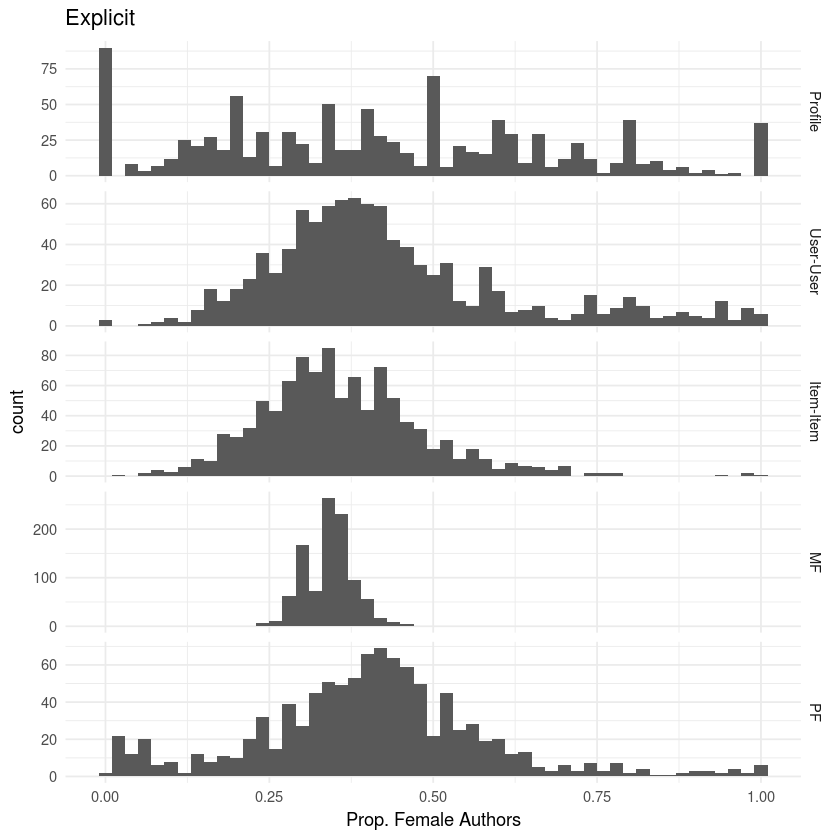

In [16]:
drawplot(file="../build/bx-explicit-hist", width=3, height=5, {
    ggplot(data=filter(user.gender_info, Algorithm != 'Popular', Algorithm != 'Mean')) +
        aes(x=PropFemale) +
        geom_histogram(binwidth=0.02) + 
        facet_grid(Algorithm ~ ., scales='free_y') +
        xlab("Prop. Female Authors") +
        ggtitle("Explicit") +
        theme_minimal()
})

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


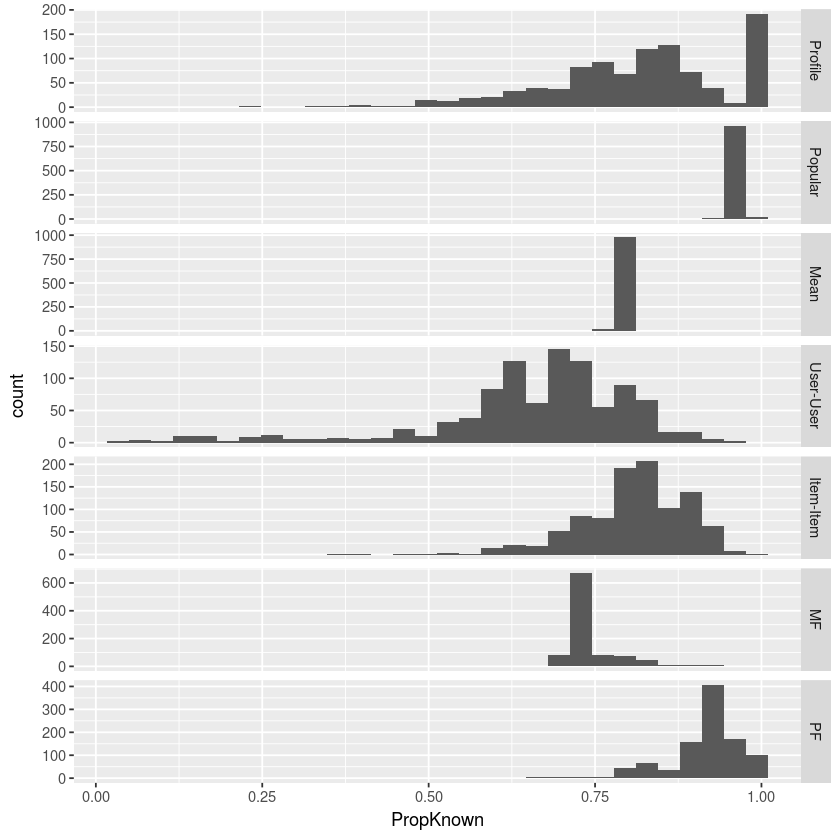

In [17]:
ggplot(data=user.gender_info, aes(x=PropKnown)) + geom_histogram() + facet_grid(Algorithm ~ ., scales='free_y')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


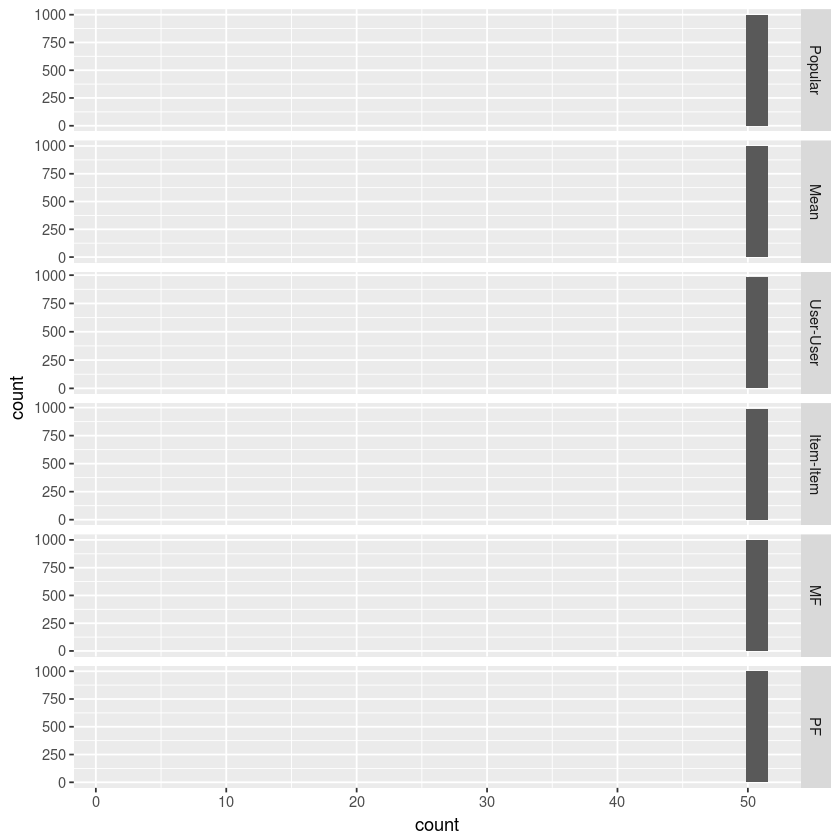

In [18]:
ggplot(data=user.gender_info %>% filter(Algorithm != 'Profile'), aes(x=count)) +
    geom_histogram() +
    facet_grid(Algorithm ~ ., scales='free_y')

# Initial Data Summary

In [15]:
proportion_by_algorithm =  user.gender_info %>% 
                            group_by(Algorithm) %>% 
                            summarize(AvgFemaleProp = sum(NFemale) / sum(known),
                                      PropAvg = mean(PropFemale),
                                      PropSD = sd(PropFemale))
proportion_by_algorithm

Algorithm,AvgFemaleProp,PropAvg,PropSD
Profile,0.4332745,0.4205748,0.264019089
Popular,0.4935844,0.4935768,0.014670404
Mean,0.3241915,0.3241579,0.007713966
User-User,0.4292270,0.4340037,0.191534733
Item-Item,0.3595236,0.3625371,0.126588233
MF,0.3413001,0.3413863,0.039921657
PF,0.4037298,0.4048237,0.176967494


In [16]:
user.gender_info = user.gender_info %>%
    filter(known > 0) %>%
    mutate(Proportion = NFemale/known)
summary(user.gender_info)

     userID           count           matched         ambiguous     
 Min.   :   114   Min.   :  1.00   Min.   :  1.00   Min.   :0.0000  
 1st Qu.: 65549   1st Qu.: 50.00   1st Qu.: 43.00   1st Qu.:0.0000  
 Median :137588   Median : 50.00   Median : 46.00   Median :0.0000  
 Mean   :136431   Mean   : 46.36   Mean   : 42.25   Mean   :0.1992  
 3rd Qu.:207953   3rd Qu.: 50.00   3rd Qu.: 49.00   3rd Qu.:0.0000  
 Max.   :278854   Max.   :563.00   Max.   :505.00   Max.   :9.0000  
                                                                    
     known            NMale           NFemale        PropFemale    
 Min.   :  1.00   Min.   :  0.00   Min.   :  0.0   Min.   :0.0000  
 1st Qu.: 36.00   1st Qu.: 21.00   1st Qu.: 11.0   1st Qu.:0.3250  
 Median : 40.00   Median : 24.00   Median : 13.0   Median :0.3611  
 Mean   : 37.46   Mean   : 22.56   Mean   : 14.9   Mean   :0.3972  
 3rd Qu.: 46.00   3rd Qu.: 27.00   3rd Qu.: 20.0   3rd Qu.:0.5000  
 Max.   :451.00   Max.   :202.00   Max. 

# Densities in transformed Space

In [17]:
dens.points = ddply(user.gender_info, .(Algorithm), function(df) {
    xydensity(x=seq(-5, 5, 0.1), y=seq(-10, 25, 0.1), 
              counts=df$NFemale,
              totals=df$known,
              loglike=pure_loglike)
}, .parallel=TRUE)

dens.points

Algorithm,x,y,alpha,beta,logPrior,logLike,rawLogPost,logJacobian,logPost
Profile,-5.0,-10,3.038550e-07,4.509607e-05,25,-23450.14,-23425.14,-25.01343,-23450.16
Profile,-4.9,-10,3.355755e-07,4.506435e-05,25,-23360.46,-23335.46,-24.91484,-23360.38
Profile,-4.8,-10,3.705802e-07,4.502935e-05,25,-23270.92,-23245.92,-24.81639,-23270.73
Profile,-4.7,-10,4.092031e-07,4.499073e-05,25,-23181.52,-23156.52,-24.71811,-23181.24
Profile,-4.6,-10,4.518111e-07,4.494812e-05,25,-23092.30,-23067.30,-24.62000,-23091.92
Profile,-4.5,-10,4.988064e-07,4.490112e-05,25,-23003.26,-22978.26,-24.52210,-23002.78
Profile,-4.4,-10,5.506301e-07,4.484930e-05,25,-22914.42,-22889.42,-24.42441,-22913.84
Profile,-4.3,-10,6.077651e-07,4.479216e-05,25,-22825.81,-22800.81,-24.32695,-22825.13
Profile,-4.2,-10,6.707400e-07,4.472919e-05,25,-22737.44,-22712.44,-24.22977,-22736.67
Profile,-4.1,-10,7.401323e-07,4.465980e-05,25,-22649.35,-22624.35,-24.13287,-22648.48


In [18]:
nrow(dens.points)

[1] 248157

In [19]:
dens.points %>% filter(logPost > 0)

Algorithm,x,y,alpha,beta,logPrior,logLike,rawLogPost,logJacobian,logPost


In [20]:
summary(dens.points %>% select(logLike, logPost))

    logLike           logPost       
 Min.   :-136833   Min.   :-136850  
 1st Qu.: -50181   1st Qu.: -50194  
 Median : -35307   Median : -35318  
 Mean   : -43174   Mean   : -43181  
 3rd Qu.: -28310   3rd Qu.: -28315  
 Max.   : -11851   Max.   : -11853  

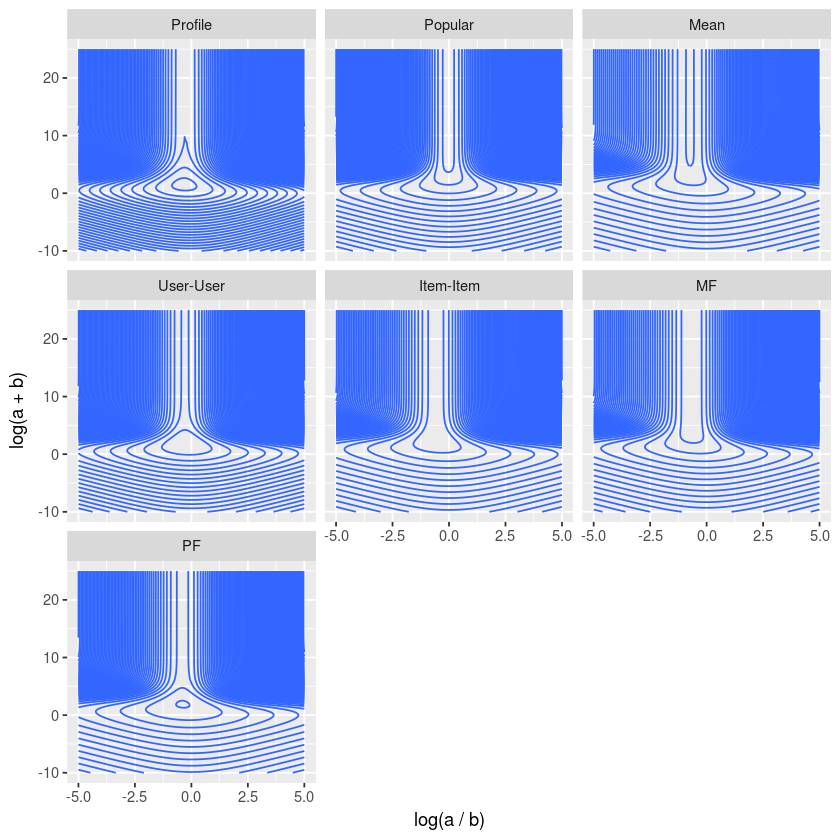

In [21]:
ggplot(dens.points) +
    aes(x=x, y=y, z=logPost) +
    geom_contour(bins=100) +
    xlab("log(a / b)") +
    ylab("log(a + b)") +
    facet_wrap(~ Algorithm)

# Inference for Parameter Values

In [22]:
expvals = function(dens) {
    normPost = dens$logPost - max(dens$logPost)
    alpha = sum(dens$alpha * exp(normPost)) / sum(exp(normPost))
    beta = sum(dens$beta * exp(normPost)) / sum(exp(normPost))
    x = log(alpha / beta)
    y = log(alpha + beta)
    mean = alpha / (alpha + beta)
    data.frame(alpha=alpha, beta=beta, x=x, y=y, mean=mean)
}

In [23]:
ddply(dens.points, .(Algorithm), expvals)

Algorithm,alpha,beta,x,y,mean
Profile,1.867999e+00,2.530361e+00,-3.034943e-01,1.481232,0.4247035
Popular,2.226483e+07,2.226483e+07,-2.153833e-14,17.611666,0.5000000
Mean,1.491872e+07,3.004262e+07,-7.000002e-01,17.621314,0.3318122
User-User,3.111928e+00,3.827179e+00,-2.068854e-01,1.937173,0.4484623
Item-Item,8.183489e+00,1.490848e+01,-5.998117e-01,3.139485,0.3543868
MF,1.229637e+07,2.475755e+07,-6.998261e-01,17.427885,0.3318508
PF,2.714069e+00,4.046810e+00,-3.994798e-01,1.911153,0.4014373


# Integral Inference for the Posterior

In [24]:
summary(dens.points$logLike)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-136833  -50181  -35307  -43174  -28310  -11851 

In [25]:
algo.maxlp = dens.points %>% group_by(Algorithm) %>% summarize(MaxLP = max(logPost))
algo.maxlp

Algorithm,MaxLP
Profile,-11853.23
Popular,-33283.86
Mean,-25142.78
User-User,-20669.06
Item-Item,-25766.84
MF,-23783.29
PF,-29038.54


In [26]:
theta.post = user.gender_info %>% filter(Algorithm != 'Popular', Algorithm != 'Mean') %>%
    ddply(.(Algorithm), function(df) {
        dfa = unique(df$Algorithm)
        message("processing algorithm ", dfa, " with ", nrow(df), " users")
        maxlp = filter(algo.maxlp, Algorithm == dfa)$MaxLP
        res = data.frame(Theta=seq(0.01, 0.99, 0.005)) %>%
            mutate(RawPostDens = model.theta.post(Theta, maxlp * 0.99,
                                                  counts=df$NFemale, totals=df$known,
                                                  parallel=TRUE,
                                                  loglike=pure_loglike)) %>%
            mutate(PostDens = RawPostDens / sum(RawPostDens * 0.005)) %>%
            mutate(CumDens = cumsum(PostDens[order(Theta)]) / sum(PostDens))
        message("finished algorithm ", dfa)
        res
    }) %>%
    mutate(CIMax = if_else(CumDens >= 0.025 & CumDens <= 0.975, PostDens, 0))

processing algorithm Profile with 1000 users
finished algorithm Profile
processing algorithm User-User with 984 users
finished algorithm User-User
processing algorithm Item-Item with 995 users
finished algorithm Item-Item
processing algorithm MF with 1000 users
finished algorithm MF
processing algorithm PF with 1000 users
finished algorithm PF


In [27]:
post_sum = theta.post %>%
    group_by(Algorithm) %>%
    summarize(mean = sum(Theta * PostDens) / sum(PostDens),
              cimin=Theta[which(CumDens >= 0.025)[1]],
              cimax=Theta[which(CumDens > 0.975)[1]]) %>%
    ungroup() %>%
    inner_join(rename(proportion_by_algorithm, RawMean=AvgFemaleProp))
post_sum

Joining, by = "Algorithm"


Algorithm,mean,cimin,cimax,RawMean,PropAvg,PropSD
Profile,0.4415429,0.075,0.860,0.4332745,0.4205748,0.26401909
User-User,0.4255878,0.115,0.775,0.4292270,0.4340037,0.19153473
Item-Item,0.3744171,0.195,0.575,0.3595236,0.3625371,0.12658823
MF,0.3360542,0.205,0.480,0.3413001,0.3413863,0.03992166
PF,0.4255874,0.115,0.775,0.4037298,0.4048237,0.17696749


In [28]:
means = post_sum %>%
    select(Algorithm, Posterior=mean, Raw=RawMean) %>%
    melt(id.vars = "Algorithm") %>%
    rename(Mean=variable)
means

Algorithm,Mean,value
Profile,Posterior,0.4415429
User-User,Posterior,0.4255878
Item-Item,Posterior,0.3744171
MF,Posterior,0.3360542
PF,Posterior,0.4255874
Profile,Raw,0.4332745
User-User,Raw,0.4292270
Item-Item,Raw,0.3595236
MF,Raw,0.3413001
PF,Raw,0.4037298


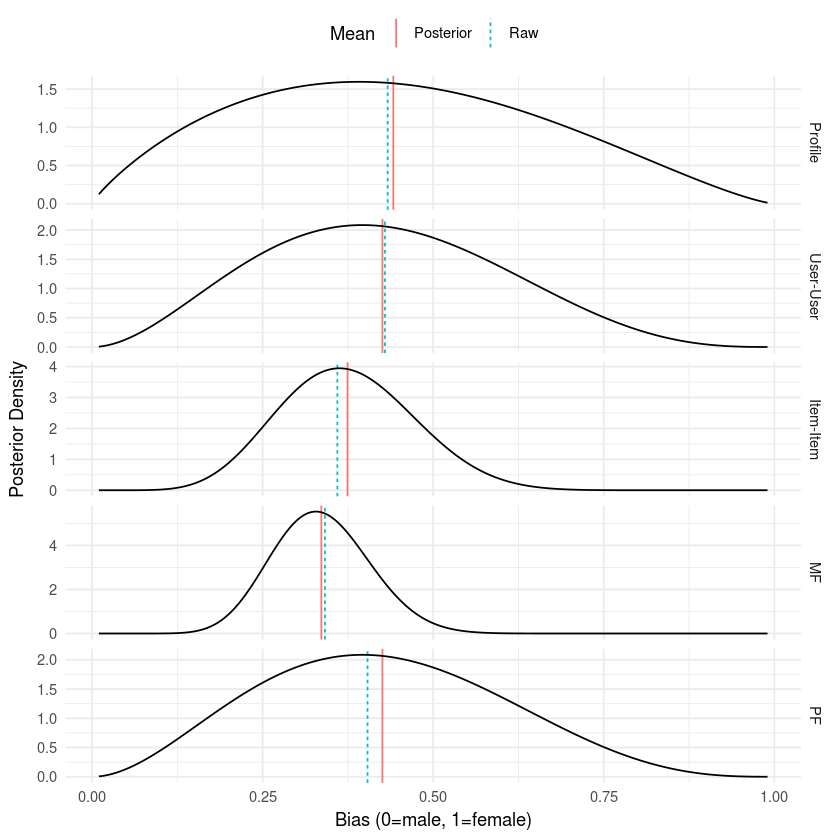

In [29]:
drawplot(file="../build/explicit-posteriors", width=5, height=6, {
    ggplot(theta.post) +
        aes(x=Theta, y=PostDens, ymax=CIMax) +
        geom_vline(data=means, aes(xintercept=value, color=Mean, linetype=Mean)) +
        geom_line() +
        facet_grid(Algorithm ~ ., scales='free_y') +
        xlab("Bias (0=male, 1=female)") +
        ylab("Posterior Density") +
        theme_minimal() +
        theme(legend.position="top")
})

## Scatterplots

In [32]:
joined.info = user.rec_info %>%
    dcast(userID ~ Algorithm, value.var=c("PropFemale")) %>%
    select(userID, `User-User`=UserUser, `Item-Item`=ItemItem, MF=FunkSVD, PF=PF) %>%
    inner_join(user.rating_info %>% select(userID, Input=PropFemale)) %>%
    melt(id.vars = c("userID", "Input"), variable.name = "Algorithm", value.name = "Output")

Joining, by = "userID"


`geom_smooth()` using method = 'gam'
Warning message:
“Removed 21 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 21 rows containing missing values (geom_point).”`geom_smooth()` using method = 'gam'
Warning message:
“Removed 21 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 21 rows containing missing values (geom_point).”`geom_smooth()` using method = 'gam'
Warning message:
“Removed 21 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 21 rows containing missing values (geom_point).”

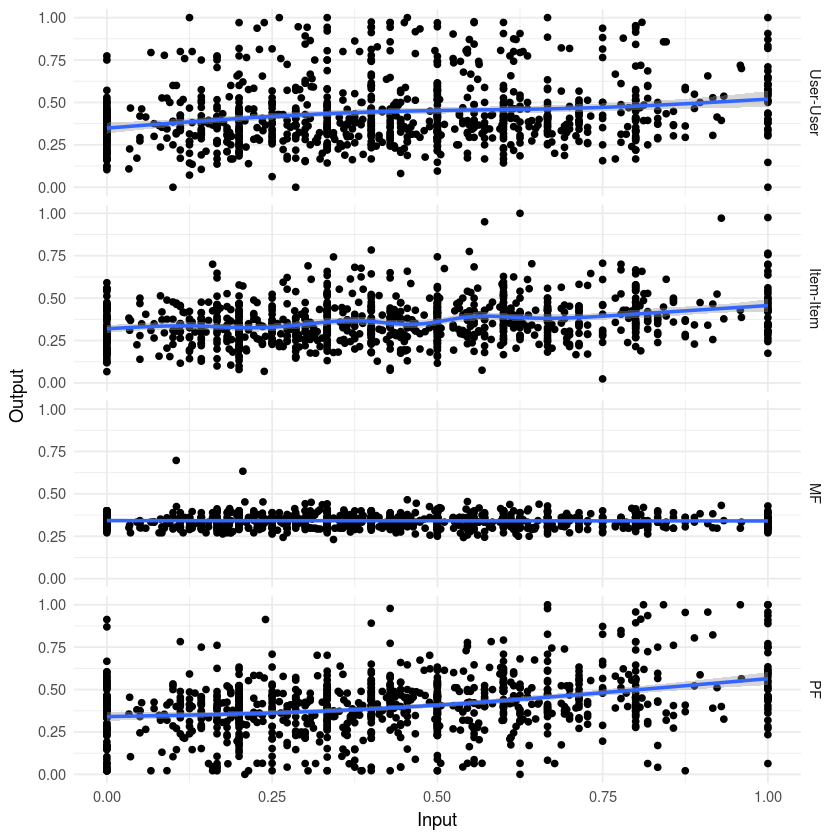

In [33]:
drawplot(file="../build/explicit-scatter", width=5, height=5, {
    ggplot(joined.info) +
        aes(x=Input, y=Output) +
        geom_point() +
        geom_smooth() +
        facet_grid(Algorithm ~ .) +
        theme_minimal()
})

In [34]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'User-User'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "User-User")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52101 -0.12225 -0.03838  0.07142  0.61063 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.37056    0.01132  32.727  < 2e-16 ***
Input        0.15045    0.02281   6.597 6.84e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1875 on 982 degrees of freedom
  (16 observations deleted due to missingness)
Multiple R-squared:  0.04244,	Adjusted R-squared:  0.04146 
F-statistic: 43.52 on 1 and 982 DF,  p-value: 6.842e-11


In [35]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'Item-Item'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "Item-Item")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37847 -0.07995 -0.01054  0.06552  0.61289 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.31127    0.00735  42.351  < 2e-16 ***
Input        0.12135    0.01477   8.218 6.42e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1226 on 993 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.06368,	Adjusted R-squared:  0.06274 
F-statistic: 67.53 on 1 and 993 DF,  p-value: 6.419e-16


In [36]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'MF'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "MF")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.11109 -0.02737 -0.00627  0.02048  0.35367 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.343939   0.002375 144.843   <2e-16 ***
Input       -0.006069   0.004783  -1.269    0.205    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03991 on 998 degrees of freedom
Multiple R-squared:  0.001611,	Adjusted R-squared:  0.0006107 
F-statistic: 1.611 on 1 and 998 DF,  p-value: 0.2047


In [37]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'PF'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "PF")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48243 -0.09579  0.00211  0.08998  0.59974 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.313306   0.009964   31.44   <2e-16 ***
Input       0.217603   0.020068   10.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1675 on 998 degrees of freedom
Multiple R-squared:  0.1054,	Adjusted R-squared:  0.1045 
F-statistic: 117.6 on 1 and 998 DF,  p-value: < 2.2e-16


In [38]:
joined.info %>%
    group_by(Algorithm) %>%
    summarize(Cor=cor(Input, Output, use="pairwise.complete.obs")) %>%
    mutate(R2=Cor*Cor)

Algorithm,Cor,R2
User-User,0.20600730,0.042439007
Item-Item,0.25234758,0.063679300
MF,-0.04013896,0.001611136
PF,0.32464291,0.105393019
